In [1]:
%pip install pandas numpy torch tqdm seaborn matplotlib

You should consider upgrading via the '/Users/Rafa/Documents/Code/BC/COMPUTER SCIENCE/DL/LOBnet/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys
sys.path.append('..')

import torch
import os
import torch.nn as nn
import pandas as pd 
import numpy as np
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from LOBnet.Models import TransformerLOB
from LOBnet.Orderbooks import FI2010_Orderbook_Optimized

In [2]:
datapath = "../data/BenchmarkDatasets_csv"
window_size = 100
overlap_percent = 25  # 25% overlap between windows
num_workers = 6


In [3]:
# initialize dataset
dataset = FI2010_Orderbook_Optimized(
    root_path=datapath,
    venue="NoAuction",
    normalization_type="Zscore",
    split="Training",
    window_size=window_size,
    overlap_percent=overlap_percent,
    num_workers=num_workers, 
    verbose=True
)

Processing CSV Files:   0%|          | 0/9 [00:00<?, ?it/s]

Processing file: ../data/BenchmarkDatasets_csv/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_7.csv
Processing file: ../data/BenchmarkDatasets_csv/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_2.csv
Processing file: ../data/BenchmarkDatasets_csv/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_6.csv
Processing file: ../data/BenchmarkDatasets_csv/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_1.csv
Processing file: ../data/BenchmarkDatasets_csv/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_4.csv
Processing file: ../data/BenchmarkDatasets_csv/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_3.csv


Processing CSV Files:  11%|█         | 1/9 [00:06<00:49,  6.19s/it]

Processing file: ../data/BenchmarkDatasets_csv/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_5.csv


Processing CSV Files:  22%|██▏       | 2/9 [00:13<00:48,  7.00s/it]

Processing file: ../data/BenchmarkDatasets_csv/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_8.csv


Processing CSV Files:  33%|███▎      | 3/9 [00:18<00:36,  6.00s/it]

Processing file: ../data/BenchmarkDatasets_csv/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_9.csv


Processing CSV Files: 100%|██████████| 9/9 [04:58<00:00, 33.21s/it]



Raw price movement statistics:
Mean: 1.9929
Std: 0.8862
Min: 1.0000
Max: 3.0000

Label distribution:
0    8931
1    4838
2    8771
Name: count, dtype: int64


In [4]:
# create train/test splits (80/20)
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

train_dataset, test_dataset = random_split(
    dataset, 
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False,
    collate_fn=lambda batch: (
        torch.stack([x[0] for x in batch]).transpose(1, 2).unsqueeze(1),
        torch.stack([x[1] for x in batch])
    )
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False,
    collate_fn=lambda batch: (
        torch.stack([x[0] for x in batch]).transpose(1, 2).unsqueeze(1),
        torch.stack([x[1] for x in batch])
    )   
)

print(f"Total dataset size: {total_size}")
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Total dataset size: 22540
Training set size: 18032
Test set size: 4508


In [5]:
# look at first batch
for batch in train_loader:
    batch_X, batch_y = batch  # unpack batch tuple
    print(f"Batch X shape: {batch_X.shape}")  # should be (batch_size, 100, 40)
    print(f"Batch y shape: {batch_y.shape}")
    break

Batch X shape: torch.Size([32, 1, 100, 40])
Batch y shape: torch.Size([32, 3])


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# training config
batch_size = 128  
learning_rate = 0.001  
num_epochs = 50

# init model and optimizer
model = TransformerLOB(y_len=3, device=device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3, 
    verbose=True
)
criterion = nn.CrossEntropyLoss()

# save best model to best_transformer.pth
best_val_loss = float('inf')
best_model_path = 'best_transformer.pth'

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # training phase
    model.train()
    total_train_loss = 0
    train_batches = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    
    for batch_X, batch_y in train_batches:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        train_batches.set_postfix({'loss': loss.item()})
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # val phaseee
    model.eval()
    total_val_loss = 0
    val_batches = tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
    
    with torch.no_grad():
        for batch_X, batch_y in val_batches:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_val_loss += loss.item()
            val_batches.set_postfix({'loss': loss.item()})
    
    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    
    # update learning rate
    scheduler.step(avg_val_loss)
    
    # save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses
        }, best_model_path)
        print(f'\nNew best model saved! Validation Loss: {avg_val_loss:.4f}')
    
    print(f'\nEpoch {epoch+1}/{num_epochs}:')
    print(f'Average Training Loss: {avg_train_loss:.4f}')
    print(f'Average Validation Loss: {avg_val_loss:.4f}')

/Users/Rafa/Documents/Code/BC/COMPUTER SCIENCE/DL/LOBnet/venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


New best model saved! Validation Loss: 1.0426

Epoch 1/50:
Average Training Loss: 1.0572
Average Validation Loss: 1.0426


Epoch 2/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


New best model saved! Validation Loss: 1.0174

Epoch 2/50:
Average Training Loss: 1.0386
Average Validation Loss: 1.0174


Epoch 3/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.9748

Epoch 3/50:
Average Training Loss: 1.0113
Average Validation Loss: 0.9748


Epoch 4/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.9342

Epoch 4/50:
Average Training Loss: 0.9792
Average Validation Loss: 0.9342


Epoch 5/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.9205

Epoch 5/50:
Average Training Loss: 0.9452
Average Validation Loss: 0.9205


Epoch 6/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.8586

Epoch 6/50:
Average Training Loss: 0.9063
Average Validation Loss: 0.8586


Epoch 7/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.8514

Epoch 7/50:
Average Training Loss: 0.8803
Average Validation Loss: 0.8514


Epoch 8/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.8234

Epoch 8/50:
Average Training Loss: 0.8539
Average Validation Loss: 0.8234


Epoch 9/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.8103

Epoch 9/50:
Average Training Loss: 0.8409
Average Validation Loss: 0.8103


Epoch 10/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.8054

Epoch 10/50:
Average Training Loss: 0.8249
Average Validation Loss: 0.8054


Epoch 11/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.7944

Epoch 11/50:
Average Training Loss: 0.8108
Average Validation Loss: 0.7944


Epoch 12/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 12/50:
Average Training Loss: 0.8012
Average Validation Loss: 0.8095


Epoch 13/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.7901

Epoch 13/50:
Average Training Loss: 0.7935
Average Validation Loss: 0.7901


Epoch 14/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 14/50:
Average Training Loss: 0.7851
Average Validation Loss: 0.7926


Epoch 15/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 15/50:
Average Training Loss: 0.7769
Average Validation Loss: 0.8001


Epoch 16/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.7869

Epoch 16/50:
Average Training Loss: 0.7707
Average Validation Loss: 0.7869


Epoch 17/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.7813

Epoch 17/50:
Average Training Loss: 0.7617
Average Validation Loss: 0.7813


Epoch 18/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.7607

Epoch 18/50:
Average Training Loss: 0.7524
Average Validation Loss: 0.7607


Epoch 19/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 19/50:
Average Training Loss: 0.7433
Average Validation Loss: 0.7711


Epoch 20/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.7551

Epoch 20/50:
Average Training Loss: 0.7420
Average Validation Loss: 0.7551


Epoch 21/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 21/50:
Average Training Loss: 0.7366
Average Validation Loss: 0.7622


Epoch 22/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 22/50:
Average Training Loss: 0.7304
Average Validation Loss: 0.7604


Epoch 23/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.7505

Epoch 23/50:
Average Training Loss: 0.7297
Average Validation Loss: 0.7505


Epoch 24/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 24/50:
Average Training Loss: 0.7264
Average Validation Loss: 0.7610


Epoch 25/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 25/50:
Average Training Loss: 0.7185
Average Validation Loss: 0.7628


Epoch 26/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 26/50:
Average Training Loss: 0.7148
Average Validation Loss: 0.7679


Epoch 27/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.7496

Epoch 27/50:
Average Training Loss: 0.7144
Average Validation Loss: 0.7496


Epoch 28/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.7321

Epoch 28/50:
Average Training Loss: 0.7034
Average Validation Loss: 0.7321


Epoch 29/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 29/50:
Average Training Loss: 0.6999
Average Validation Loss: 0.7352


Epoch 30/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 30/50:
Average Training Loss: 0.6932
Average Validation Loss: 0.7378


Epoch 31/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 31/50:
Average Training Loss: 0.6982
Average Validation Loss: 0.7821


Epoch 32/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 32/50:
Average Training Loss: 0.6910
Average Validation Loss: 0.7439


Epoch 33/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.7319

Epoch 33/50:
Average Training Loss: 0.6602
Average Validation Loss: 0.7319


Epoch 34/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.7287

Epoch 34/50:
Average Training Loss: 0.6511
Average Validation Loss: 0.7287


Epoch 35/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.7266

Epoch 35/50:
Average Training Loss: 0.6458
Average Validation Loss: 0.7266


Epoch 36/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 36/50:
Average Training Loss: 0.6419
Average Validation Loss: 0.7345


Epoch 37/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.7206

Epoch 37/50:
Average Training Loss: 0.6402
Average Validation Loss: 0.7206


Epoch 38/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 38/50:
Average Training Loss: 0.6368
Average Validation Loss: 0.7308


Epoch 39/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.7162

Epoch 39/50:
Average Training Loss: 0.6372
Average Validation Loss: 0.7162


Epoch 40/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 40/50:
Average Training Loss: 0.6316
Average Validation Loss: 0.7327


Epoch 41/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 41/50:
Average Training Loss: 0.6277
Average Validation Loss: 0.7167


Epoch 42/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 42/50:
Average Training Loss: 0.6242
Average Validation Loss: 0.7266


Epoch 43/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 43/50:
Average Training Loss: 0.6211
Average Validation Loss: 0.7206


Epoch 44/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 44/50:
Average Training Loss: 0.6036
Average Validation Loss: 0.7210


Epoch 45/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 45/50:
Average Training Loss: 0.5969
Average Validation Loss: 0.7262


Epoch 46/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 46/50:
Average Training Loss: 0.5990
Average Validation Loss: 0.7196


Epoch 47/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 47/50:
Average Training Loss: 0.5961
Average Validation Loss: 0.7173


Epoch 48/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 48/50:
Average Training Loss: 0.5838
Average Validation Loss: 0.7234


Epoch 49/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 49/50:
Average Training Loss: 0.5832
Average Validation Loss: 0.7231


Epoch 50/50 [Train]:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 50/50:
Average Training Loss: 0.5816
Average Validation Loss: 0.7191


In [8]:
def evaluate_model(model, test_loader, device):
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            
            # convert one-hot encoded outputs to class predictions
            predictions = outputs.argmax(dim=1)
            true_labels = batch_y.argmax(dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(true_labels.cpu().numpy())
    
    return all_predictions, all_labels

Loading saved model from best_transformer.pth


/var/folders/6y/rz_n_6x924d63ryw6s3z5jch0000gn/T/ipykernel_25261/3469247164.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)



Classification Report:
              precision    recall  f1-score   support

 No Movement       0.69      0.70      0.70      1833
          Up       0.76      0.67      0.71       952
        Down       0.68      0.71      0.70      1723

    accuracy                           0.70      4508
   macro avg       0.71      0.69      0.70      4508
weighted avg       0.70      0.70      0.70      4508



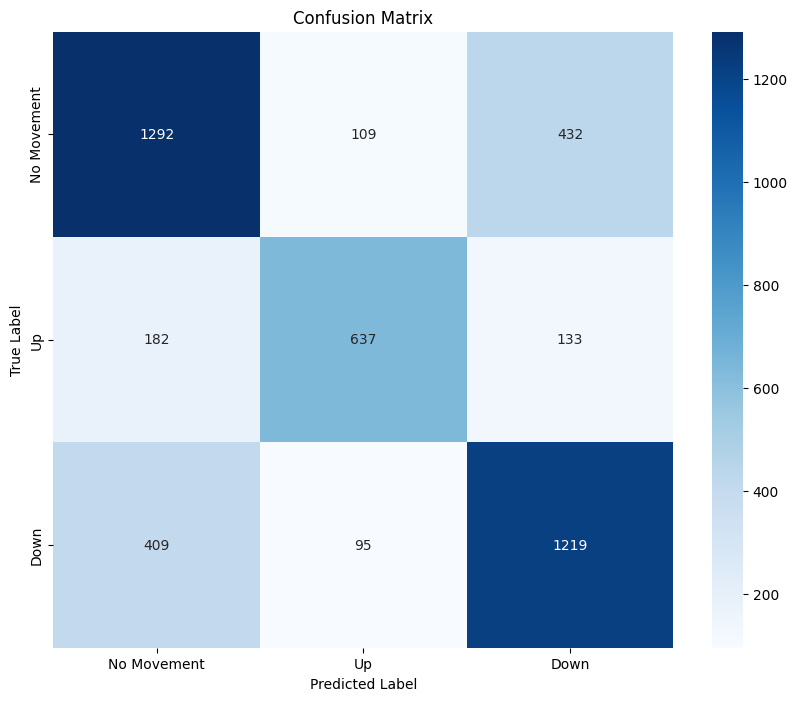

In [9]:
# load the saved model state if it exists
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = 'best_transformer.pth'
if os.path.exists(model_path):
    print(f"Loading saved model from {model_path}")
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # set to evaluation mode
else:
    print(f"No saved model found at {model_path}. Please train the model first.")
    exit()

predictions, true_labels = evaluate_model(model, test_loader, device)

print("\nClassification Report:")
print(classification_report(true_labels, predictions, 
                          target_names=['No Movement', 'Up', 'Down']))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Movement', 'Up', 'Down'],
            yticklabels=['No Movement', 'Up', 'Down'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()